# Learning with the Monge gap

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [4]:
import dataclasses
from types import MappingProxyType
from typing import Any, Dict, Iterator, Literal, Mapping, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import optax
import sklearn.datasets
from flax import linen as nn

from matplotlib import pyplot as plt

from ott.geometry import costs, pointcloud
from ott.problems.nn import dataset
from ott.solvers.linear import acceleration
from ott.solvers.nn import losses, models
from ott.tools import map_estimator, sinkhorn_divergence

## Description of the method

Let $\mu, \nu$ two probability measures and $c : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ a cost function. We seek to learn an optimal transport map $T^\star$ - a.k.a. a Monge map - between $\mu$ and $\nu$ for the cost $c$, i.e:

$$
T^\star \in \arg\min_{\substack{T:\mathbb{R}^d \rightarrow \mathbb{R}^d \\ T \sharp \mu = \nu}} \int c(x,T(x)) d\mu(x)
$$

To that end, we experiment with the {func}`~ott.solvers.nn.losses.monge_gap`, a regularizer proposed by {cite}`uscidda:23` to learn optimal transport maps for arbitrary cost functions. 

The Monge gap $\mathcal{M}_\mu^c$ is a positive functional taking as argument a map $T : \mathbb{R}^d \rightarrow \mathbb{R}^d$ and characterizing the $c$-optimality. Indeed, $\mathcal{M}_\mu^c(T) = 0$ i.f.f. $T$ is optimal between $\mu$ and $T \sharp \mu$ for the cost $c$. Using a fitting loss $\Delta$ to satisfy the transport constraint $T \sharp \mu = \nu$ and introducing a regularization weight $\lambda_\mathrm{MG} > 0$, the above problem can be reformulated as:

$$
T^\star \in \arg\min_{T:\mathbb{R}^d \rightarrow \mathbb{R}^d} \Delta(T\sharp \mu, \nu) + \lambda_\mathrm{MG} \mathcal{M}_\mu^c(T)
$$

We can solve this problem by introducing a parameterized family of maps $\{T_\theta\}_{\theta \in \mathbb{R}^d}$ with neural networks and using the {class}`~ott.tools.map_estimator.MapEstimator` solver.

For the squared-Euclidean cost, this method provides a simple alternative to the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solver. Actually, when we use the latter by parameterizing dual potentials $f_\theta, g_\theta$ with {class}`~ott.solvers.nn.models.MLP`s instead {class}`~ott.solvers.nn.models.ICNN`s, we can also use the Monge gap to penalize these potentials to deviate from being the gradient of a convex function. To that end, we just need to add $\mathcal{M}_\mu^2(\nabla f_\theta) + \mathcal{M}_\mu^2(\nabla g_\theta)$ to the loss function, where $\mathcal{M}_\mu^2$ is the Monge gap instantiated with the {func}`~ott.sinkhorn_divergence.sinkhorn_divergence` with the {class}`squared-Euclidean cost <ott.geometry.costs.SqEuclidean>`. This approach is not covered in this notebook.

## Generate data

Let's try out the Monge gap in practice with different costs $c$. First, let's generate some data.

In [90]:
@dataclasses.dataclass
class SklearnDistribution:
    """A class to define toy probability 2-dimensional distributions,
    from rotated ``moons`` and ``s_curve`` sklearn datasets.
    One can rotate the distribution by setting the ``theta_rotation``.
    """

    name: Literal["moon", "s_curve"]
    theta_rotation: float = (0.0,)
    mean: jnp.ndarray = (jnp.zeros(2),)
    noise: float = (0.01,)
    scale: float = 1.0
    batch_size: int = 1024
    init_rng: jax.random.PRNGKeyArray = jax.random.PRNGKey(0)

    def __iter__(self) -> Iterator[jnp.ndarray]:
        """Random sample generator from Gaussian mixture.

        Returns:
        A generator of samples from the Gaussian mixture.
        """
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = self.init_rng

        # define rotation matrix tp rotate samples
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=[self.batch_size, 0],
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                X, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = X[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            samples = self.mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 1024,
    valid_batch_size: int = 1024,
    rng: jax.random.PRNGKeyArray = jax.random.PRNGKey(0),
) -> Tuple[dataset.Dataset, dataset.Dataset, int]:
    """Samplers from ``SklearnDistribution``."""
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = dataset.Dataset(
        source_iter=iter(
            SklearnDistribution(
                init_rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                init_rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = dataset.Dataset(
        source_iter=iter(
            SklearnDistribution(
                init_rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                init_rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data


def plot(
    batch: Dict[str, Any],
    num_points: Optional[int] = None,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 8),
    rng: jax.random.PRNGKeyArray = jax.random.PRNGKey(0),
):
    """
    Plot samples from the source and target measures.
    If source samples mapped by the fitted map are provided in ``batch``,
    the function plots these prediction.
    """

    fig, ax = plt.subplots(figsize=figsize)
    if num_points is None:
        subsample = jnp.arange(len(batch["source"]))
    else:
        subsample = jax.random.choice(
            rng, a=len(batch["source"]), shape=(num_points,)
        )
    ax.scatter(
        batch["source"][subsample, 0],
        batch["source"][subsample, 1],
        label="source",
        c="b",
        edgecolors="k",
        s=300,
        alpha=0.8,
    )
    ax.scatter(
        batch["target"][subsample, 0],
        batch["target"][subsample, 1],
        label="target",
        c="r",
        edgecolors="k",
        marker="X",
        s=300,
        alpha=0.6,
    )
    bool_plot_pred = "mapped_source" in batch
    if "mapped_source" in batch:
        ax.scatter(
            batch["mapped_source"][subsample, 0],
            batch["mapped_source"][subsample, 1],
            label="push-forward",
            c="orange",
            edgecolors="k",
            marker="X",
            s=300,
            alpha=0.8,
        )
        z = batch["mapped_source"] - batch["source"]
        ax.quiver(
            batch["source"][subsample, 0],
            batch["source"][subsample, 1],
            z[subsample, 0],
            z[subsample, 1],
            angles="xy",
            scale_units="xy",
            scale=1.0,
            width=0.003,
            headwidth=10,
            headlength=10,
            color="dodgerblue",
            edgecolor="k",
            alpha=0.5,
        )
    if title is None:
        title = (
            r"Fitted map $\hat{T}_\theta$"
            if bool_plot_pred
            else r"Source and Target Measures"
        )
    ax.set_title(title, fontsize=30, y=1.01)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=25)
    fig.tight_layout()
    plt.show()

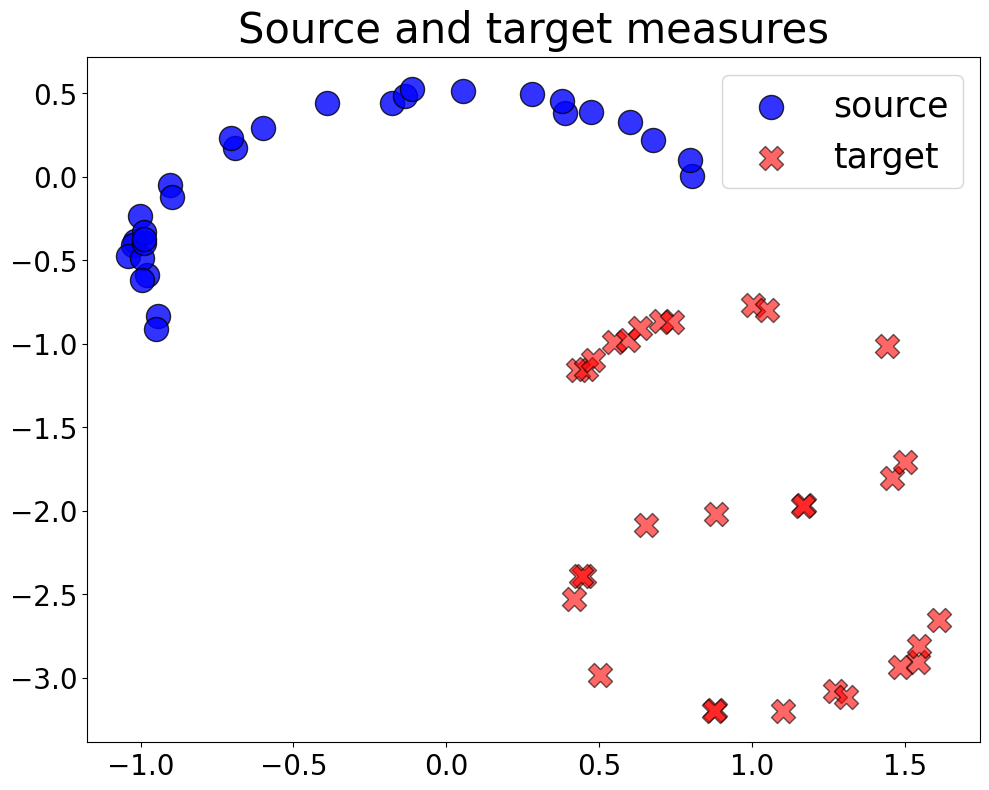

In [91]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.02,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([1.0, -2.0]),
        "theta_rotation": jnp.pi / 2,
        "noise": 0.03,
    },
)

batch = {}
batch["source"] = next(train_dataset.source_iter)
batch["target"] = next(train_dataset.target_iter)
plot(batch=batch, num_points=30)

## Learning the maps

Afterwards, we use to Monge gap to fit **(i)** an OT map for the squared-Euclidean cost $c = \ell_2^2$ and **(ii)** an OT map for the euclidean cost $c = \ell_2$. Therefore we instantiate two different Monge gaps, one for each cost. We also fit a map without Monge gap, minimizing only the fitting loss $\Delta$, to learn an arbitrary push-forward between $\mu$ and $\nu$. 

We use standard {class}`~ott.solvers.nn.models.MLP`s to parameterize the maps. For $c = \ell_2^2$, we use $\lambda_\mathrm{MG} = 1$ and for $c = \ell_2$ we use $\lambda_\mathrm{MG} = 2.5$. For all fittings, we use $\Delta = S_{\varepsilon, \ell_2^2}$, the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` with the {class}`squared-Euclidean cost <ott.geometry.costs.SqEuclidean>`.

In [93]:
# define fitting loss
def sinkhorn_div(
    samples: jnp.ndarray,
    mapped_samples: jnp.ndarray,
    cost_fn: Optional[costs.CostFn] = None,
    epsilon: Optional[float] = None,
    relative_epsilon: Optional[bool] = None,
    scale_cost: Union[
        bool, int, float, Literal["mean", "max_cost", "median"]
    ] = 1.0,
    sinkhorn_kwargs: Mapping[str, Any] = MappingProxyType({}),
    **kwargs: Any,
) -> Optional[float]:
    r"""Sinkhorn divergence fitting loss."""
    return sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud,
        x=samples,
        y=mapped_samples,
        relative_epsilon=relative_epsilon,
        cost_fn=cost_fn,
        epsilon=epsilon,
        scale_cost=scale_cost,
        sinkhorn_kwargs=sinkhorn_kwargs,
        **kwargs,
    ).divergence


# Rmk: we use the same geometry and sinkhorn kwargs for fitting loss
# for different Monge gaps
EPSILON = 1e-1
SINKHORN_KWARGS = {
    "momentum": acceleration.Momentum(value=1.0, start=20),
    "use_danskin": True,
}
fitting_loss = jax.tree_util.Partial(
    sinkhorn_div,
    cost_fn=costs.SqEuclidean(),
    epsilon=EPSILON,
    sinkhorn_kwargs=SINKHORN_KWARGS,
)

Fitting without Monge gap: in progress... 


100%|██████████| 5000/5000 [04:15<00:00, 19.60it/s, fitting_loss: 0.0604, monge gap: not computed.]


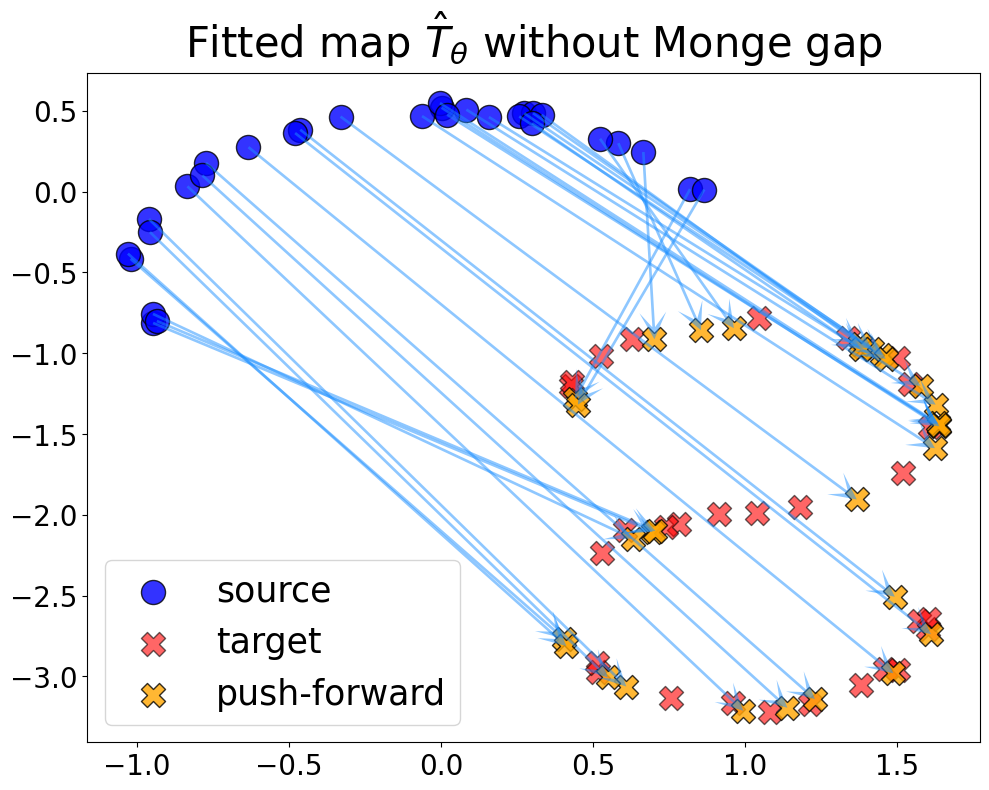

Fitting without Monge gap: done! 

Fitting with $\ell_2^2$ Monge gap: in progress... 


100%|██████████| 5000/5000 [05:12<00:00, 15.99it/s, fitting_loss: 0.0641, monge gap: 0.9018.]


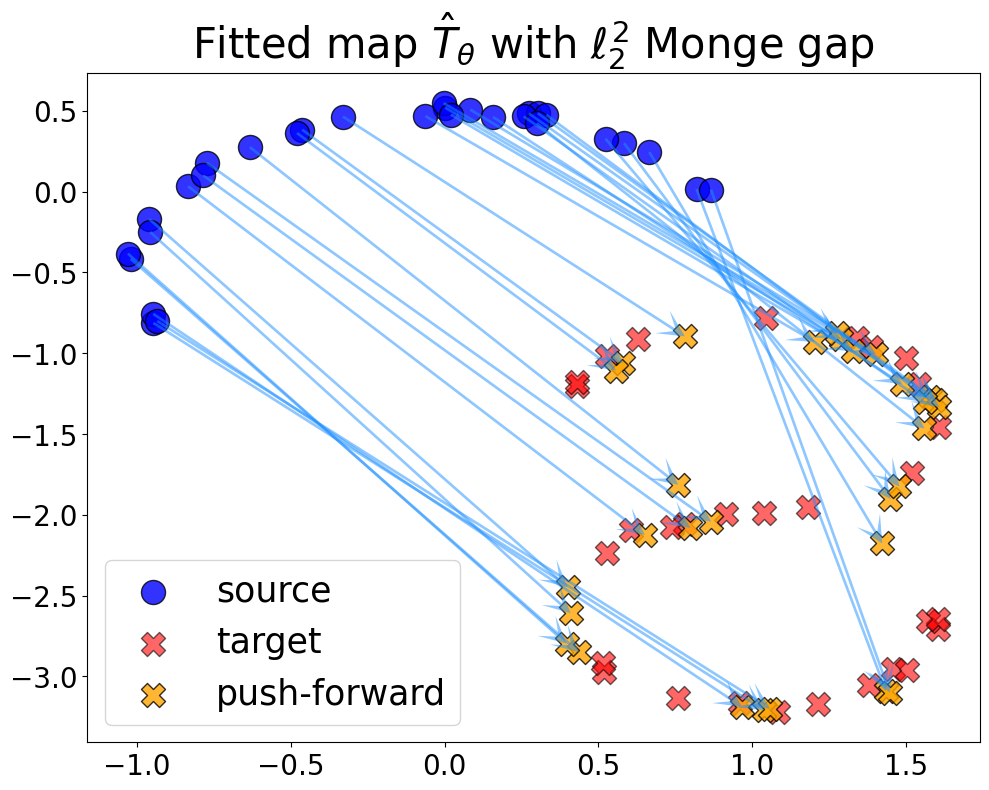

Fitting with $\ell_2^2$ Monge gap: done! 

Fitting with $\ell_2$ Monge gap: in progress... 


100%|██████████| 5000/5000 [05:02<00:00, 16.55it/s, fitting_loss: 0.0723, monge gap: 0.3241.]


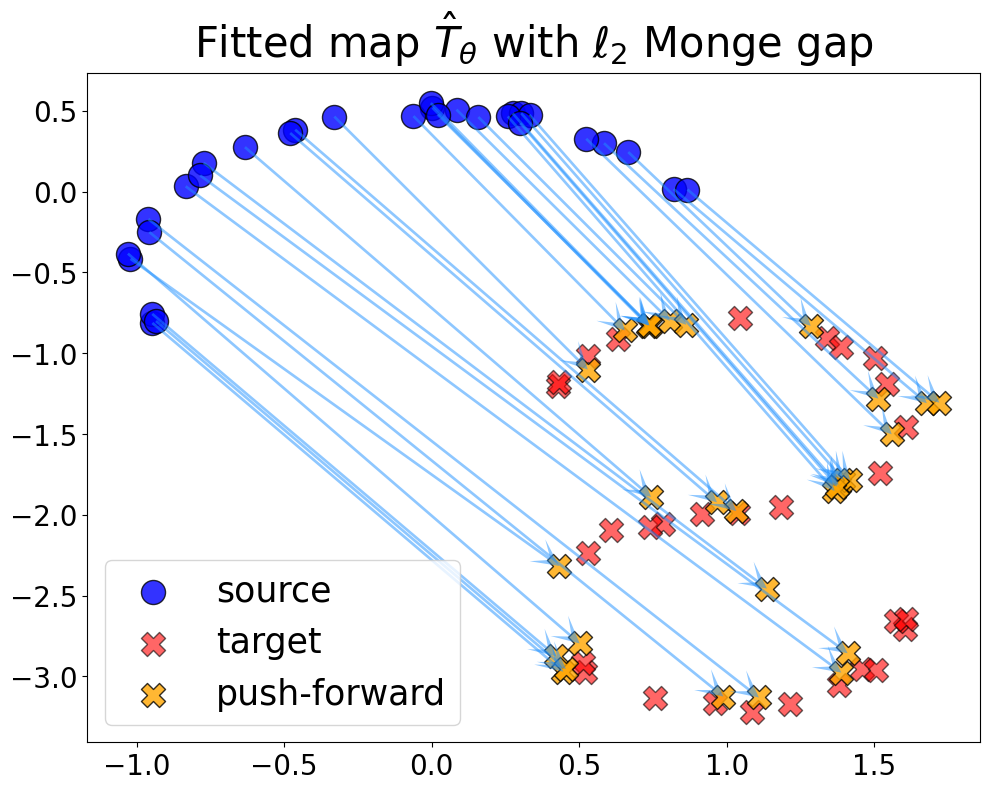

Fitting with $\ell_2$ Monge gap: done! 



In [94]:
# experimental setting
DIM_DATA = 2
NUM_TRAIN_ITERS = 5_000
LOGGING = True
VALID_FREQ = 500

# define the neural network that is our neural map
model = models.MLP(dim_hidden=[128, 64, 64], is_potential=False, act_fn=nn.gelu)

# define the optimizer to learn the neural map
optimizer = optax.adam(learning_rate=1e-2)

# %%

# we fit a map:
# - without Monge gap,
# - with squared-Euclidean Monge gap,
# - with euclidean Monge gap.
for key, cost_fn in zip(
    ["no_monge_gap", r"\ell_2", r"\ell_2^2"],
    [None, costs.Euclidean(), costs.SqEuclidean()],
):
    msg = (
        "without Monge gap"
        if key == "no_monge_gap"
        else f"with ${key}$ Monge gap"
    )
    print(f"Fitting {msg}: in progress... ")

    # define regularizer
    REGULARIZER_STRENGTH = 2.5 if key == r"\ell_2" else 1.0
    if cost_fn is None:
        regularizer = None
    else:
        regularizer = jax.tree_util.Partial(
            losses.monge_gap_from_samples,
            cost_fn=cost_fn,
            epsilon=EPSILON,
            **SINKHORN_KWARGS,
        )

    # define solver
    solver = map_estimator.MapEstimator(
        dim_data=DIM_DATA,
        fitting_loss=fitting_loss,
        regularizer=regularizer,
        model=model,
        optimizer=optimizer,
        regularizer_strength=REGULARIZER_STRENGTH,
        num_train_iters=NUM_TRAIN_ITERS,
        logging=LOGGING,
        valid_freq=VALID_FREQ,
    )

    neural_state, _ = solver.train_map_estimator(
        trainloader_source=train_dataset.source_iter,
        trainloader_target=train_dataset.target_iter,
        validloader_source=valid_dataset.source_iter,
        validloader_target=valid_dataset.target_iter,
    )

    # plot the fitted map
    batch["mapped_source"] = neural_state.apply_fn(
        {"params": neural_state.params},
        batch["source"],
    )
    plot(
        batch=batch,
        num_points=30,
        title=r"Fitted map $\hat{T}_\theta$ " + msg,
    )
    print(f"Fitting {msg}: done! \n")

As expected, the three maps we get are different. When we fit without Monge gap, we get an arbitrary push-forward, which has no reason to be optimal for any cost. For the Monge gap with $c = \ell_2$, we obtain an "needle" alignment (without crossing lines) because $c$ is a distance: this is known as the Monge Mather shortening principle (see e.g. {cite}`villani:09`). For $c = \ell_2^2$, we observe crossings when the sum of the squared diagonals of the quadrilateral induced by the points is lower than the sum of the squared sides. 